# COVID 19 Data Scraping

In [290]:
from __future__ import print_function
import pandas as pd
import datetime
import numpy as np
import os
import requests
import io
import matplotlib.pyplot as plt
import datapackage
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual,Layout
import ipywidgets as widgets
from IPython.display import display,clear_output

%config InlineBackend.figure_format = 'retina' 

plt.rcParams.update({'figure.figsize':[8,6],
                     'font.size': 12,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## COVID Data

### An overview of where the data is

The function below obtains packages from datahub and displays where which data is located

### Get Reference data for countries

Reference data is mainly used to obtain the countries population

In [4]:
response = requests.get('https://pkgstore.datahub.io/core/covid-19/reference_csv/data/4e77129370a4988e45fbf79353153c4c/reference_csv.csv')
file_object = io.StringIO(response.content.decode('utf-8'))
reference=pd.read_csv(file_object)

In [221]:
print(reference.keys().values)

['UID' 'iso2' 'iso3' 'code3' 'FIPS' 'Admin2' 'Province_State'
 'Country_Region' 'Lat' 'Long_' 'Combined_Key' 'Population']


### Get the country data aggregated

In [11]:
response = requests.get('https://datahub.io/core/covid-19/r/countries-aggregated.csv')
file_object = io.StringIO(response.content.decode('utf-8'))
data=pd.read_csv(file_object)

In [12]:
cut=data[data.Country.isin(['Italy','Germany','Switzerland','Sweden','US','Taiwan*'])]

In [13]:
for c in cut.Country.unique():
    population=float(reference[reference.Combined_Key==c].Population)
    cut.loc[cut.Country==c,'Confirmed']=cut[cut.Country==c].Confirmed*1e6/population

/Users/fci/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Plot total cases per million 

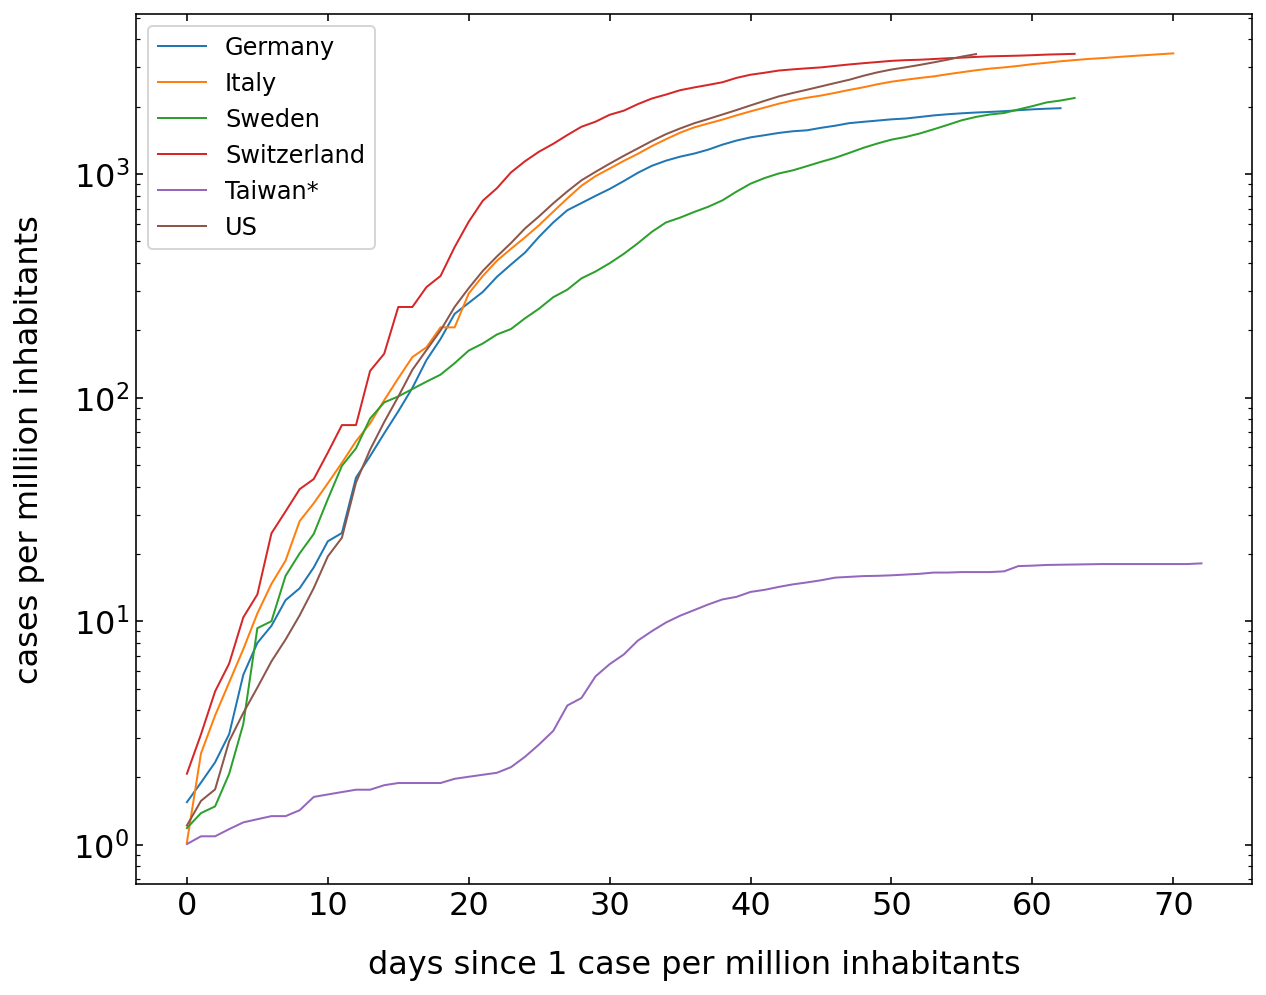

In [223]:
plt.figure(figsize=(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed.values
    
    plt.semilogy(df[df.Confirmed>1].Confirmed.values,label=c);

plt.legend()
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('cases per milliion inhabitants')
plt.show()
    

## Plot daily new cases

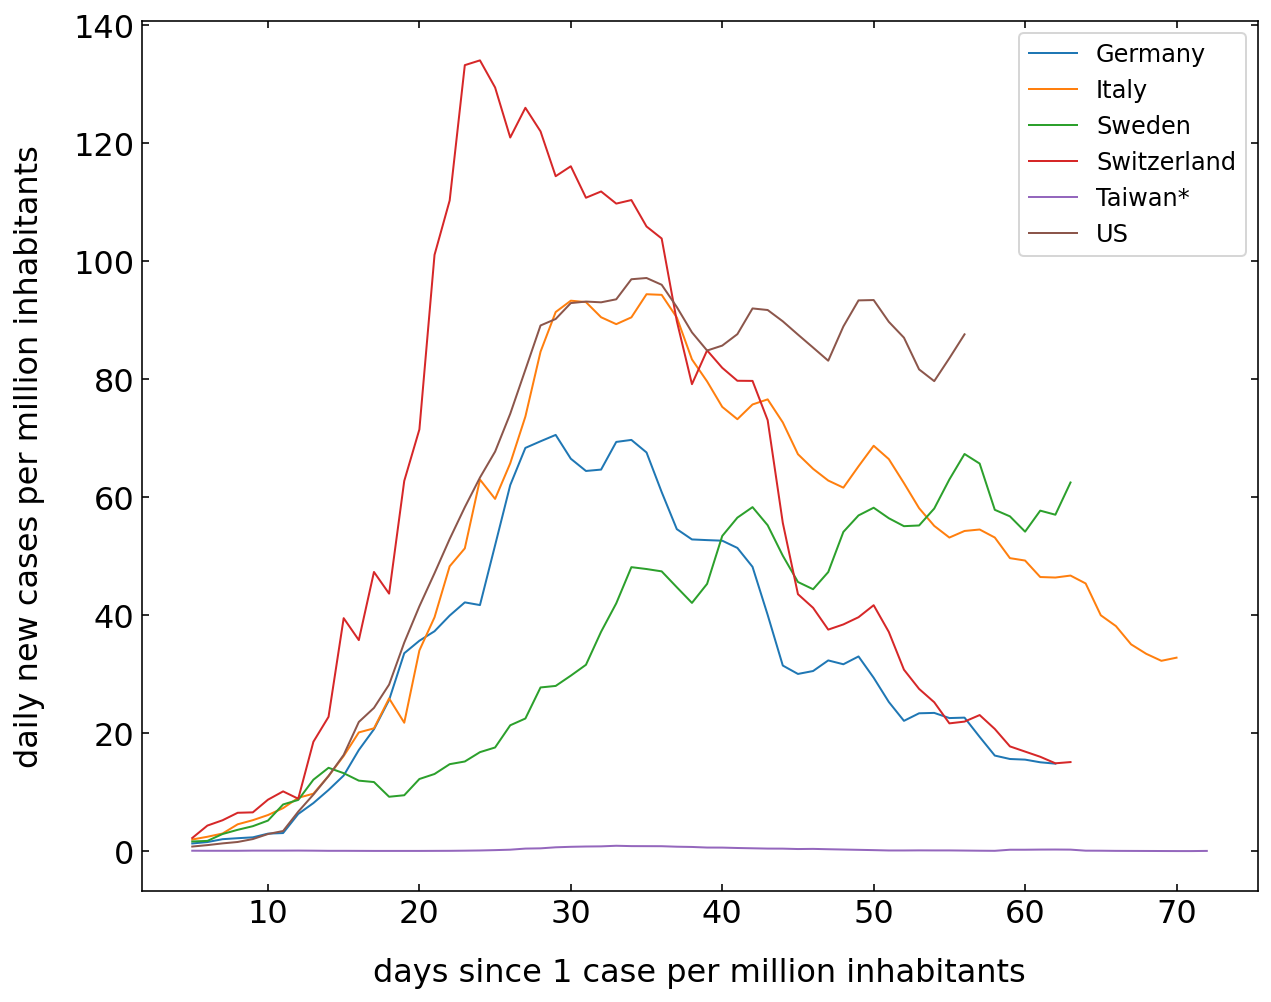

In [222]:
plt.figure(figsize=(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed
    new_cases=cases.diff().rolling(5).mean()
    
    #plt.plot(cases.diff().values,label=c);
    plt.plot(new_cases.values,label=c);

plt.legend()
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('daily new cases per million inhabitants')
plt.show()

## Testing data

**Other data sources

https://covid.ourworldindata.org/data/owid-covid-data.csv

https://github.com/owid/covid-19-data/blob/master/public/data/testing/covid-testing-all-observations.csv

https://data.humdata.org/dataset/c87c4508-9caf-4959-bf06-6ab4855d84c6/resource/8c7d6af8-c703-4904-b5d0-0ab693e54ee4/download/covid-19-tests-country.csv

In [224]:
response = requests.get("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv")

file_object = io.StringIO(response.content.decode('utf-8'))
testing=pd.read_csv(file_object,error_bad_lines=False,sep=',', index_col=None)

In [305]:
#testing.head()

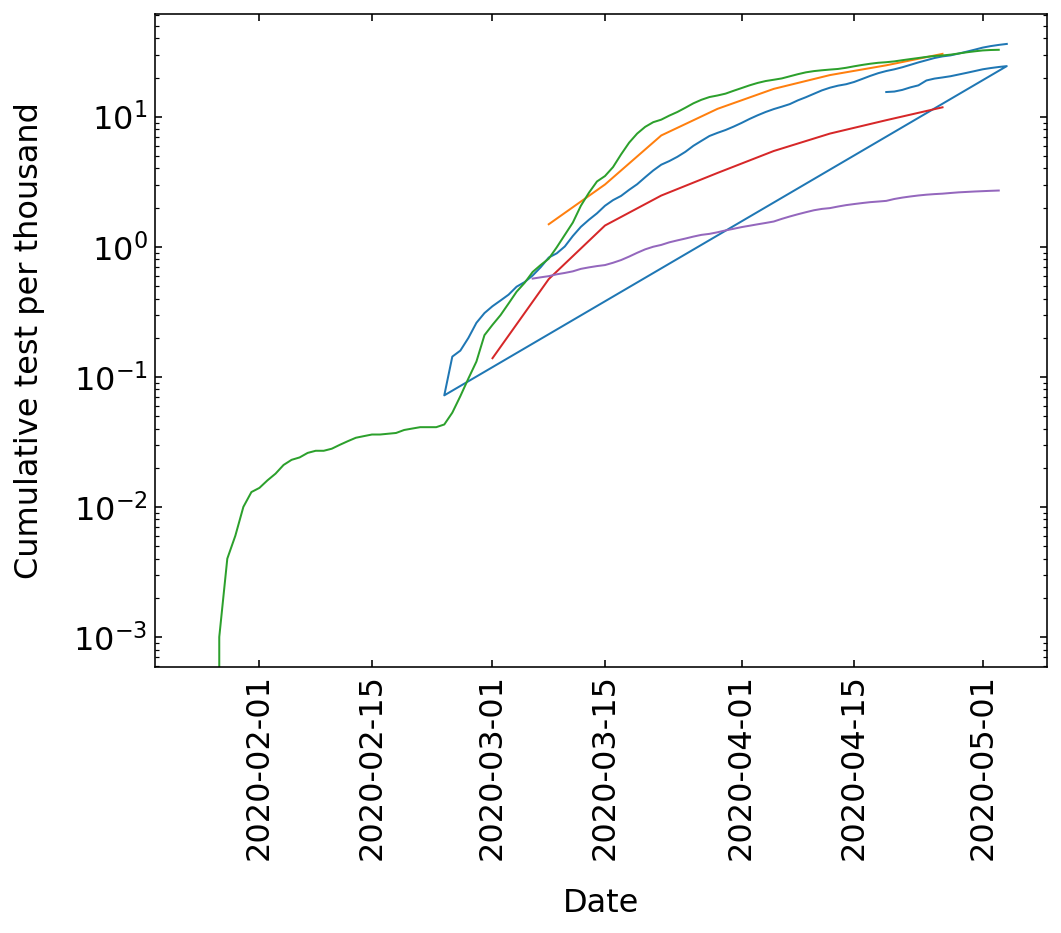

In [231]:
for country in ['Italy','Germany','Switzerland','Sweden', 'Taiwan']:
    tests=testing[testing.Entity.str.contains(country)]['Cumulative total per thousand'].values
    date=pd.to_datetime(testing[testing.Entity.str.contains(country)]['Date'])
    plt.semilogy(date,tests,'-')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Cumulative test per thousand')
plt.show()

## Apple mobility data

In [293]:
mobility=pd.read_csv('applemobilitytrends-2020-05-02.csv')

In [306]:
#mobility.head()

In [295]:
driving=mobility[mobility.transportation_type=='driving']
driving_berlin=driving[driving.region=='Berlin']

In [296]:
dates=driving_berlin.keys()[4:]

In [301]:
dow=pd.DataFrame(pd.to_datetime(dates))[0].dt.dayofweek

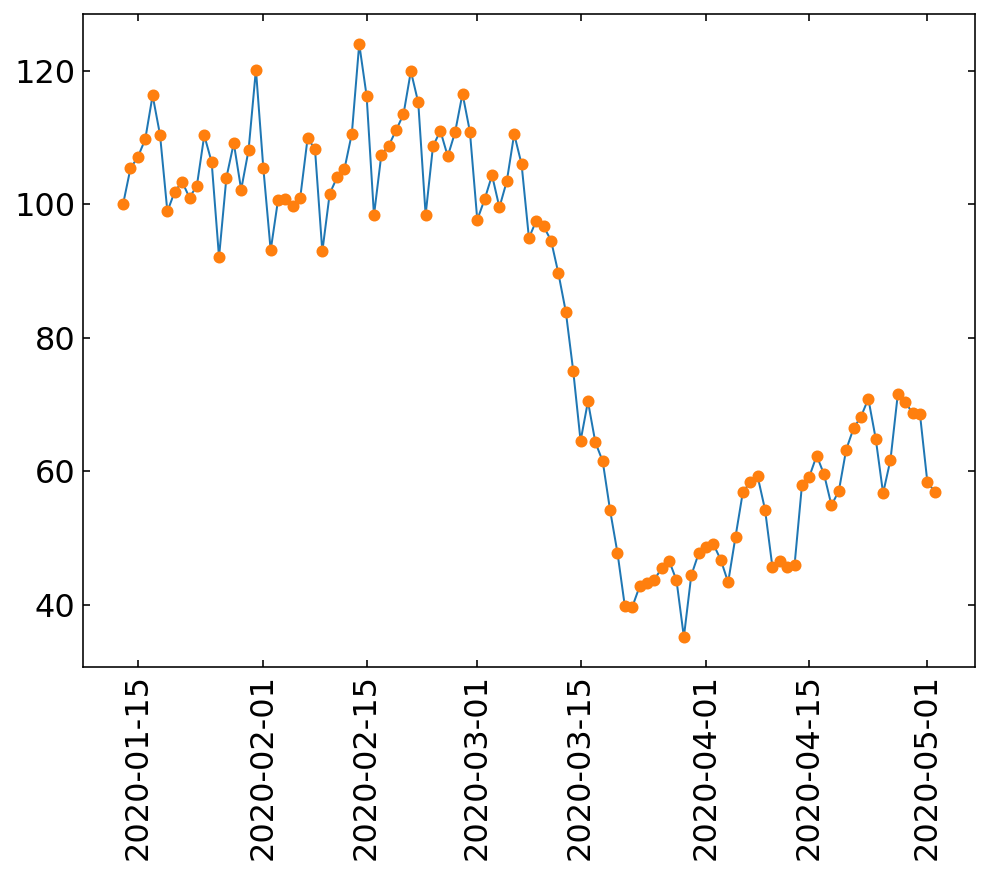

In [302]:
plt.plot(pd.to_datetime(dates),driving_berlin.iloc[0,4:])
plt.plot(pd.to_datetime(dates),driving_berlin.iloc[0,4:],'.')
plt.xticks(rotation=90)
plt.show()

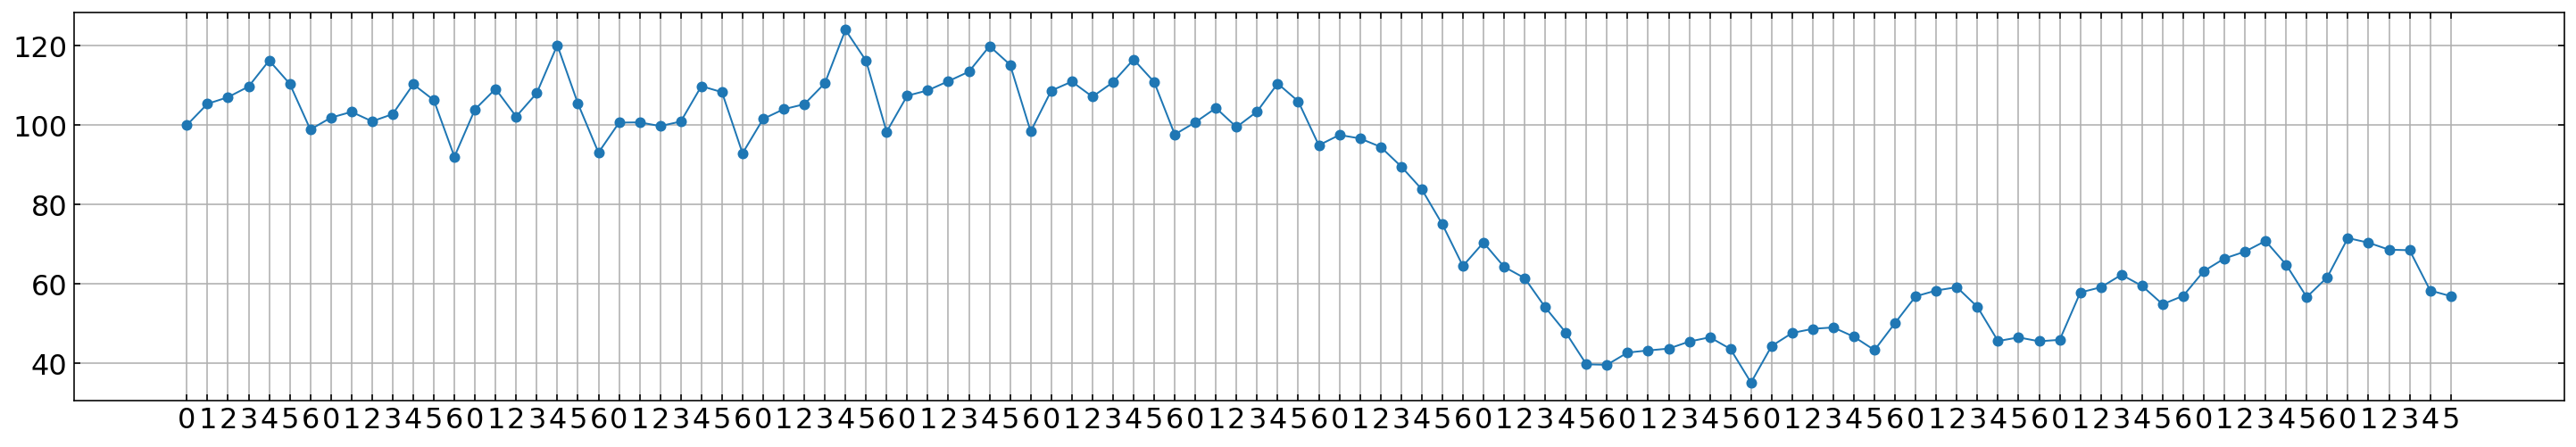

In [304]:
plt.figure(figsize=(25,4))
plt.plot(range(len(dow)),driving_berlin.iloc[0,4:],'.-')
plt.xticks(range(len(dow)),dow.values)
plt.grid()
plt.show()

## Google mobility data

https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

In [182]:
response = requests.get("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

file_object = io.StringIO(response.content.decode('utf-8'))
goo_mob=pd.read_csv('Global_Mobility_Report.csv',sep=',',low_memory=False)

In [307]:
#goo_mob.head()

### Parks
Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.

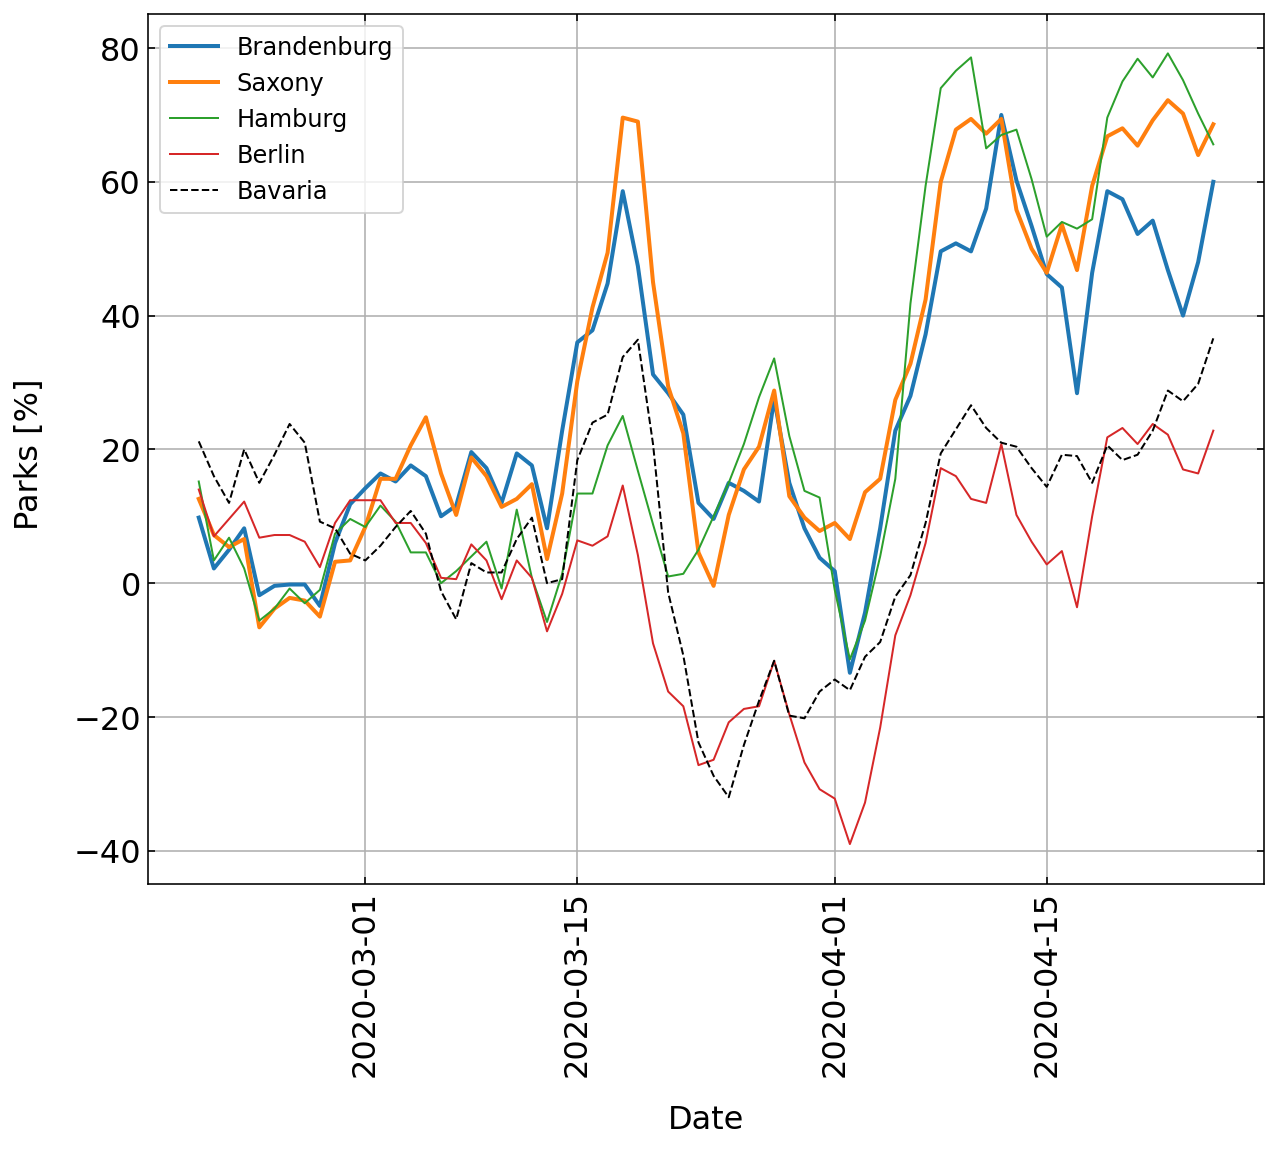

In [311]:
plt.figure(figsize=(10,8))
condition=goo_mob.sub_region_1=='Brandenburg'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].parks_percent_change_from_baseline.rolling(5).mean(),lw=2,label='Brandenburg')
condition=goo_mob.sub_region_1=='Saxony'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].parks_percent_change_from_baseline.rolling(5).mean(),lw=2,label='Saxony')
condition=goo_mob.sub_region_1=='Hamburg'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].parks_percent_change_from_baseline.rolling(5).mean(),label='Hamburg')
condition=goo_mob.sub_region_1=='Berlin'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].parks_percent_change_from_baseline.rolling(5).mean(),label='Berlin')
condition=goo_mob.sub_region_1=='Bavaria'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].parks_percent_change_from_baseline.rolling(5).mean(),'k--',label='Bavaria')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Parks [%] ')
plt.grid()
plt.show()

### Transit stations
Mobility trends for places like public transport hubs such as subway, bus, and train stations.

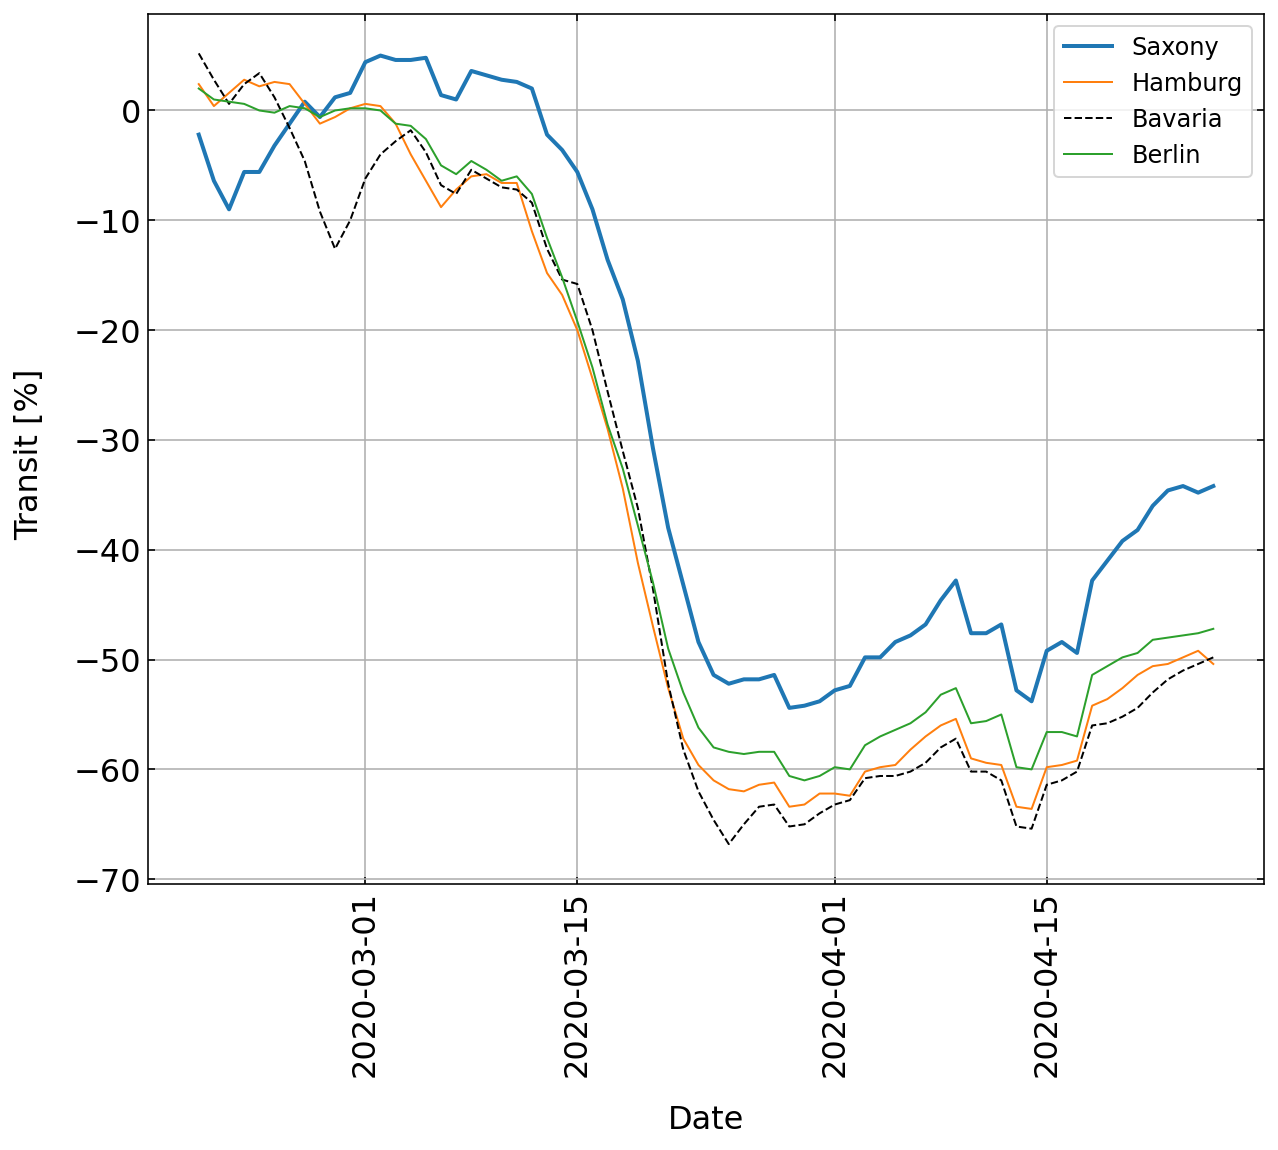

In [274]:
plt.figure(figsize=(10,8))
condition=goo_mob.sub_region_1=='Saxony'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].transit_stations_percent_change_from_baseline.rolling(5).mean(),lw=2,label='Saxony')
condition=goo_mob.sub_region_1=='Hamburg'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].transit_stations_percent_change_from_baseline.rolling(5).mean(),label='Hamburg')
condition=goo_mob.sub_region_1=='Bavaria'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].transit_stations_percent_change_from_baseline.rolling(5).mean(),'k--',label='Bavaria')
condition=goo_mob.sub_region_1=='Berlin'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].transit_stations_percent_change_from_baseline.rolling(5).mean(),label='Berlin')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Transit [%] ')
plt.grid()
plt.show()

### Workplaces
Mobility trends for places of work.

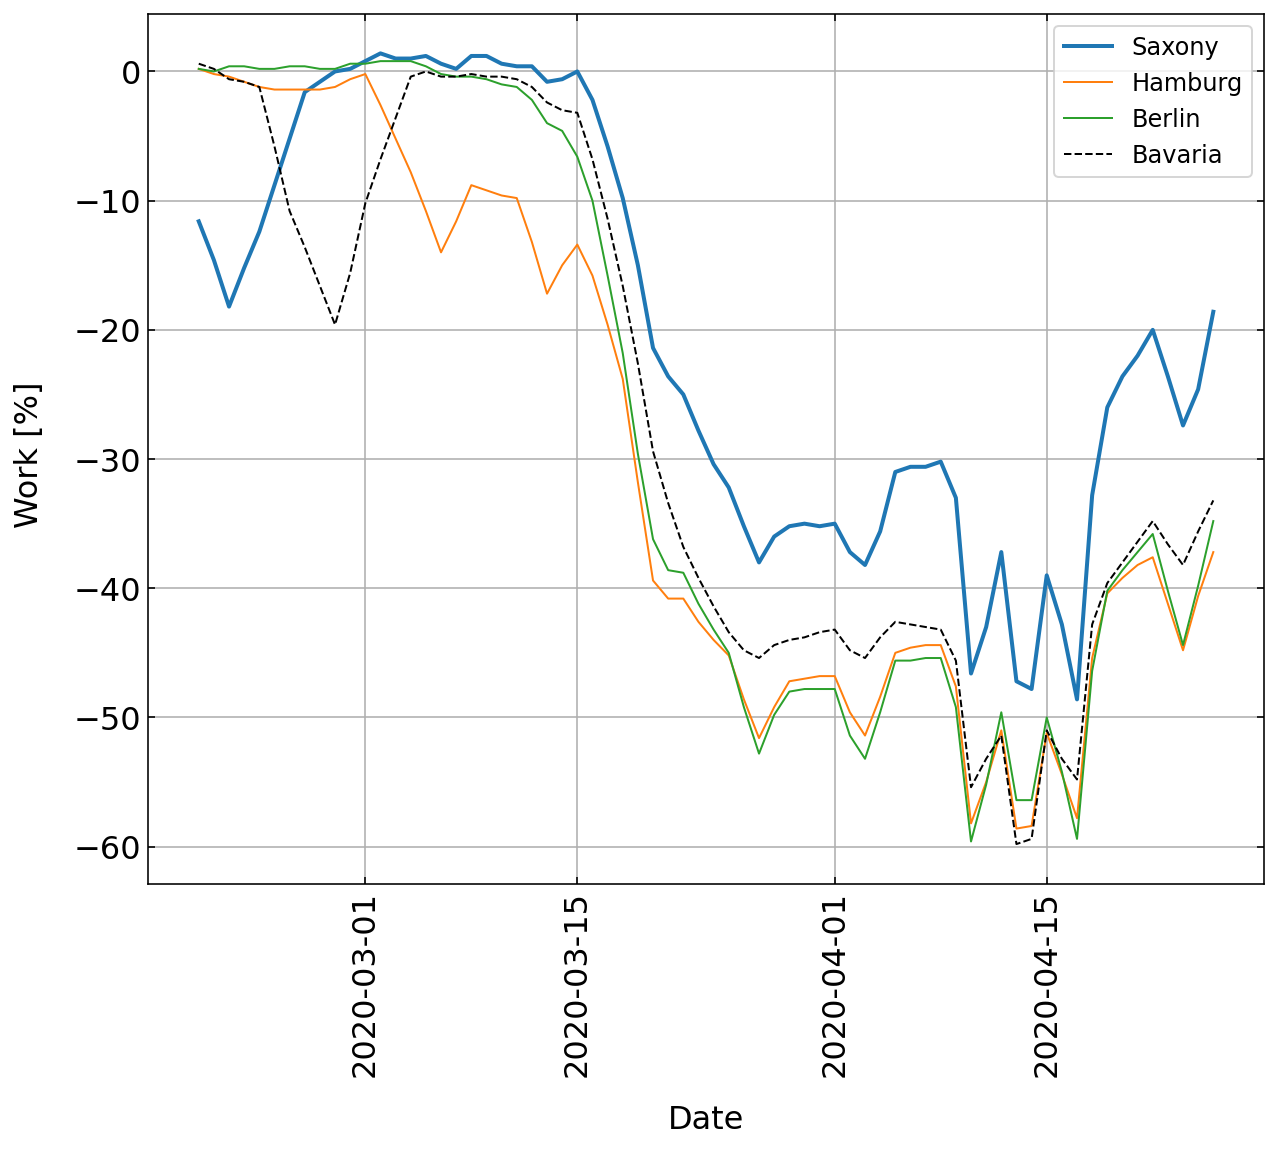

In [281]:
plt.figure(figsize=(10,8))
condition=goo_mob.sub_region_1=='Saxony'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].workplaces_percent_change_from_baseline.rolling(5).mean(),lw=2,label='Saxony')
condition=goo_mob.sub_region_1=='Hamburg'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].workplaces_percent_change_from_baseline.rolling(5).mean(),label='Hamburg')
condition=goo_mob.sub_region_1=='Berlin'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].workplaces_percent_change_from_baseline.rolling(5).mean(),label='Berlin')
condition=goo_mob.sub_region_1=='Bavaria'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].workplaces_percent_change_from_baseline.rolling(5).mean(),'k--',label='Bavaria')
plt.legend()
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Work [%] ')
plt.grid()
plt.show()

### Residential
Mobility trends for places of residence.

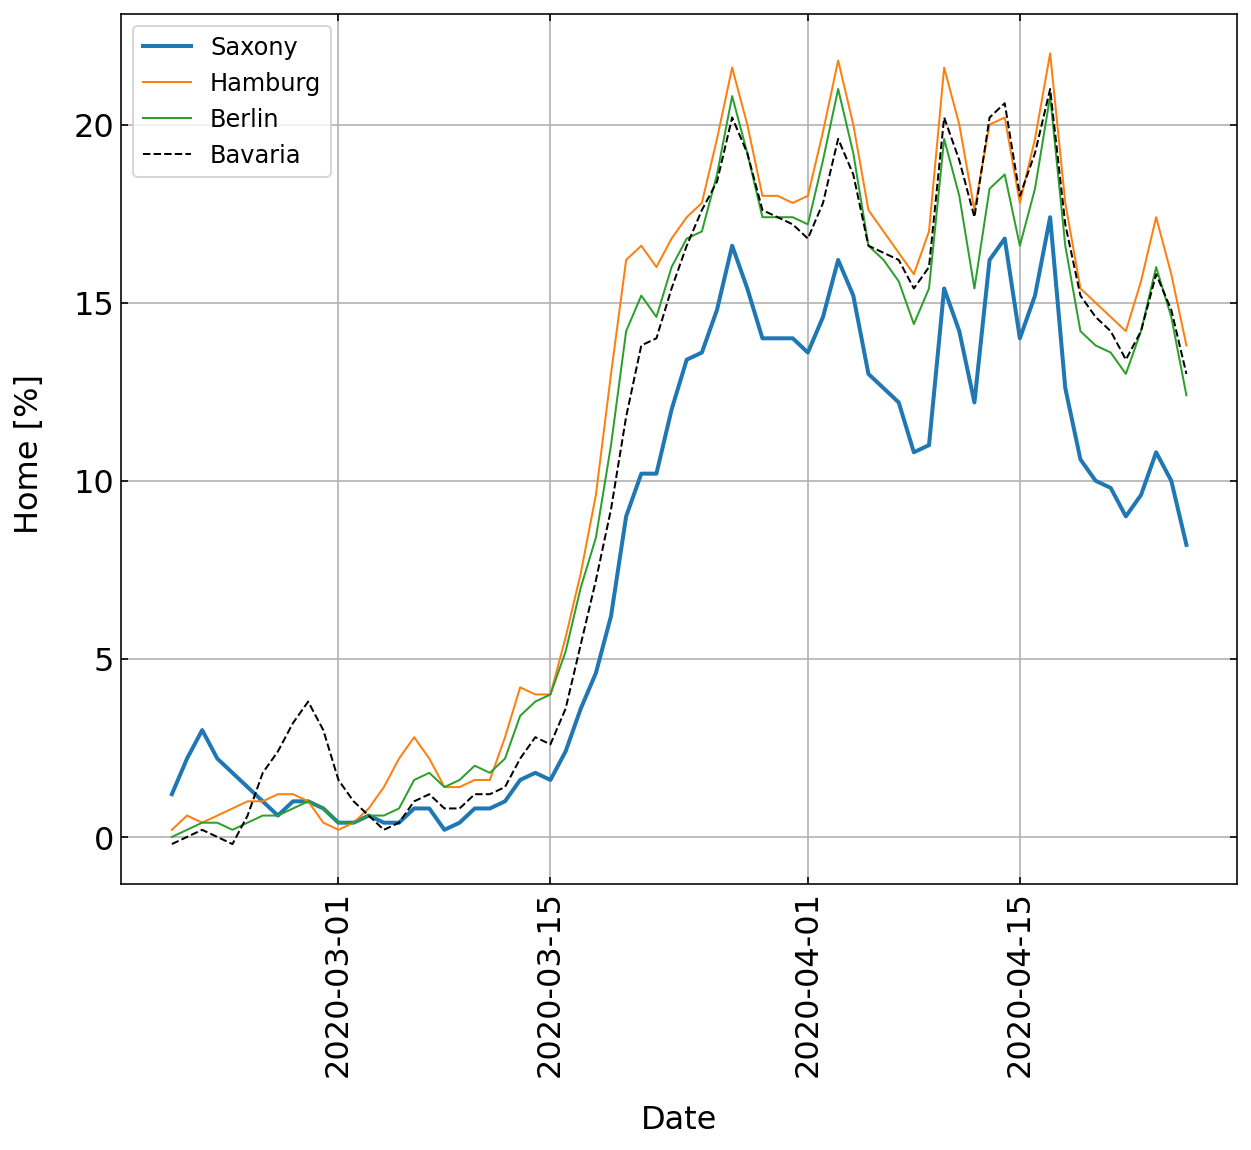

In [282]:
plt.figure(figsize=(10,8))
condition=goo_mob.sub_region_1=='Saxony'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].residential_percent_change_from_baseline.rolling(5).mean(),lw=2,label='Saxony')
condition=goo_mob.sub_region_1=='Hamburg'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].residential_percent_change_from_baseline.rolling(5).mean(),label='Hamburg')
condition=goo_mob.sub_region_1=='Berlin'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].residential_percent_change_from_baseline.rolling(5).mean(),label='Berlin')
condition=goo_mob.sub_region_1=='Bavaria'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].residential_percent_change_from_baseline.rolling(5).mean(),'k--',label='Bavaria')
plt.legend()
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Home [%] ')
plt.grid()
plt.show()

### Retail & recreation
Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.

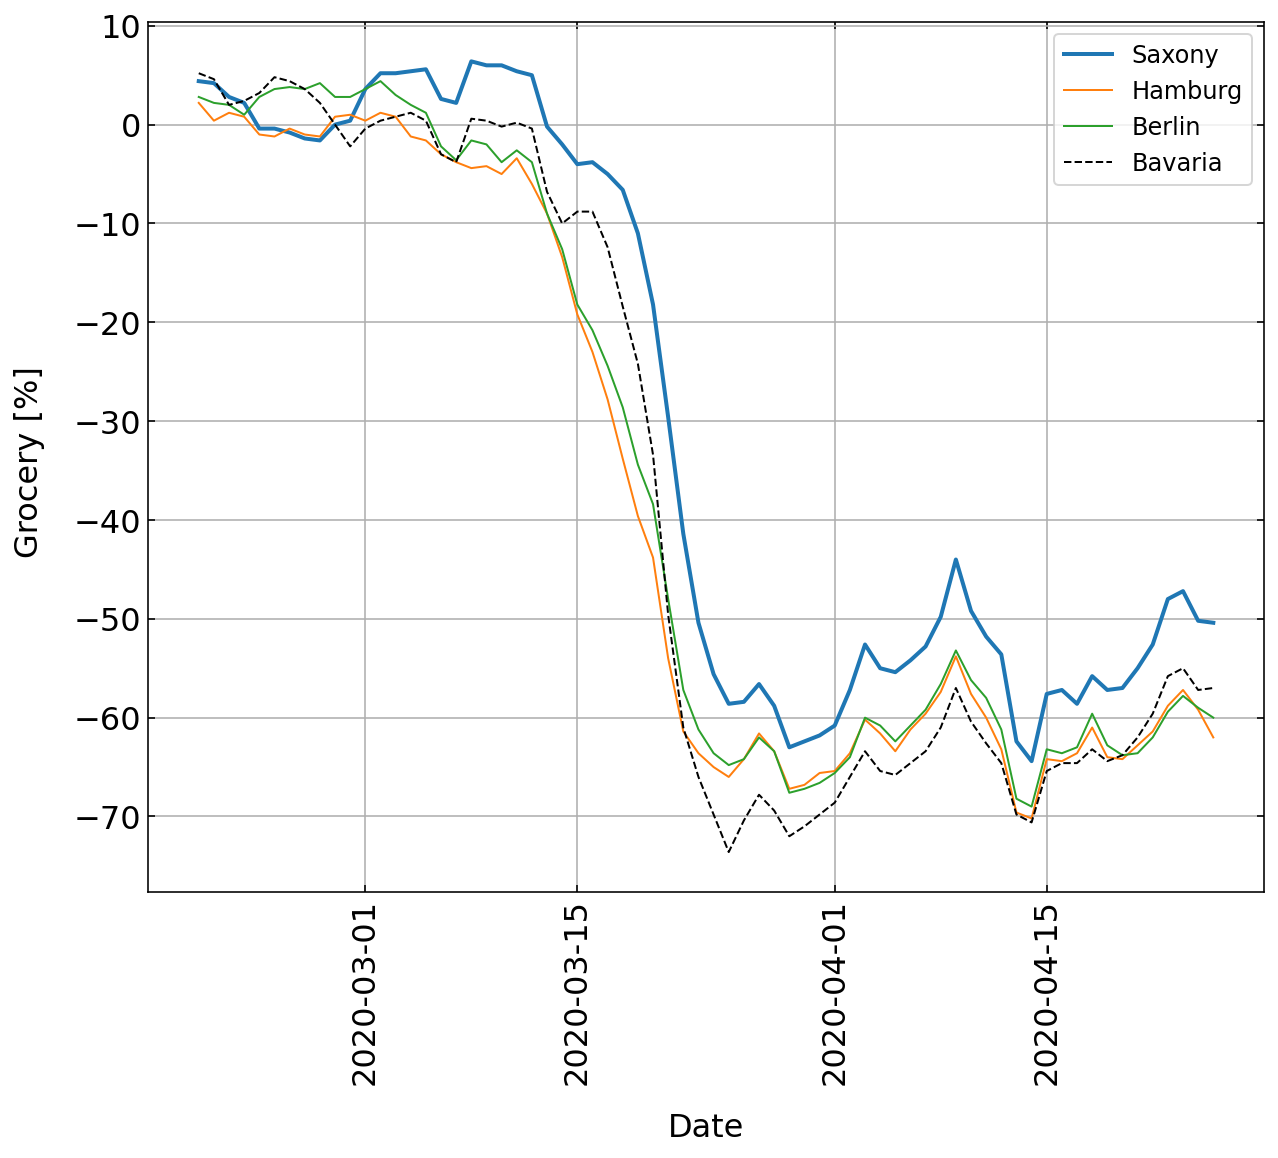

In [288]:
plt.figure(figsize=(10,8))
condition=goo_mob.sub_region_1=='Saxony'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].retail_and_recreation_percent_change_from_baseline.rolling(5).mean(),lw=2,label='Saxony')
condition=goo_mob.sub_region_1=='Hamburg'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].retail_and_recreation_percent_change_from_baseline.rolling(5).mean(),label='Hamburg')
condition=goo_mob.sub_region_1=='Berlin'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].retail_and_recreation_percent_change_from_baseline.rolling(5).mean(),label='Berlin')
condition=goo_mob.sub_region_1=='Bavaria'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].retail_and_recreation_percent_change_from_baseline.rolling(5).mean(),'k--',label='Bavaria')
plt.legend()
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Grocery [%] ')
plt.grid()
plt.show()

### Grocery & pharmacy
Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.

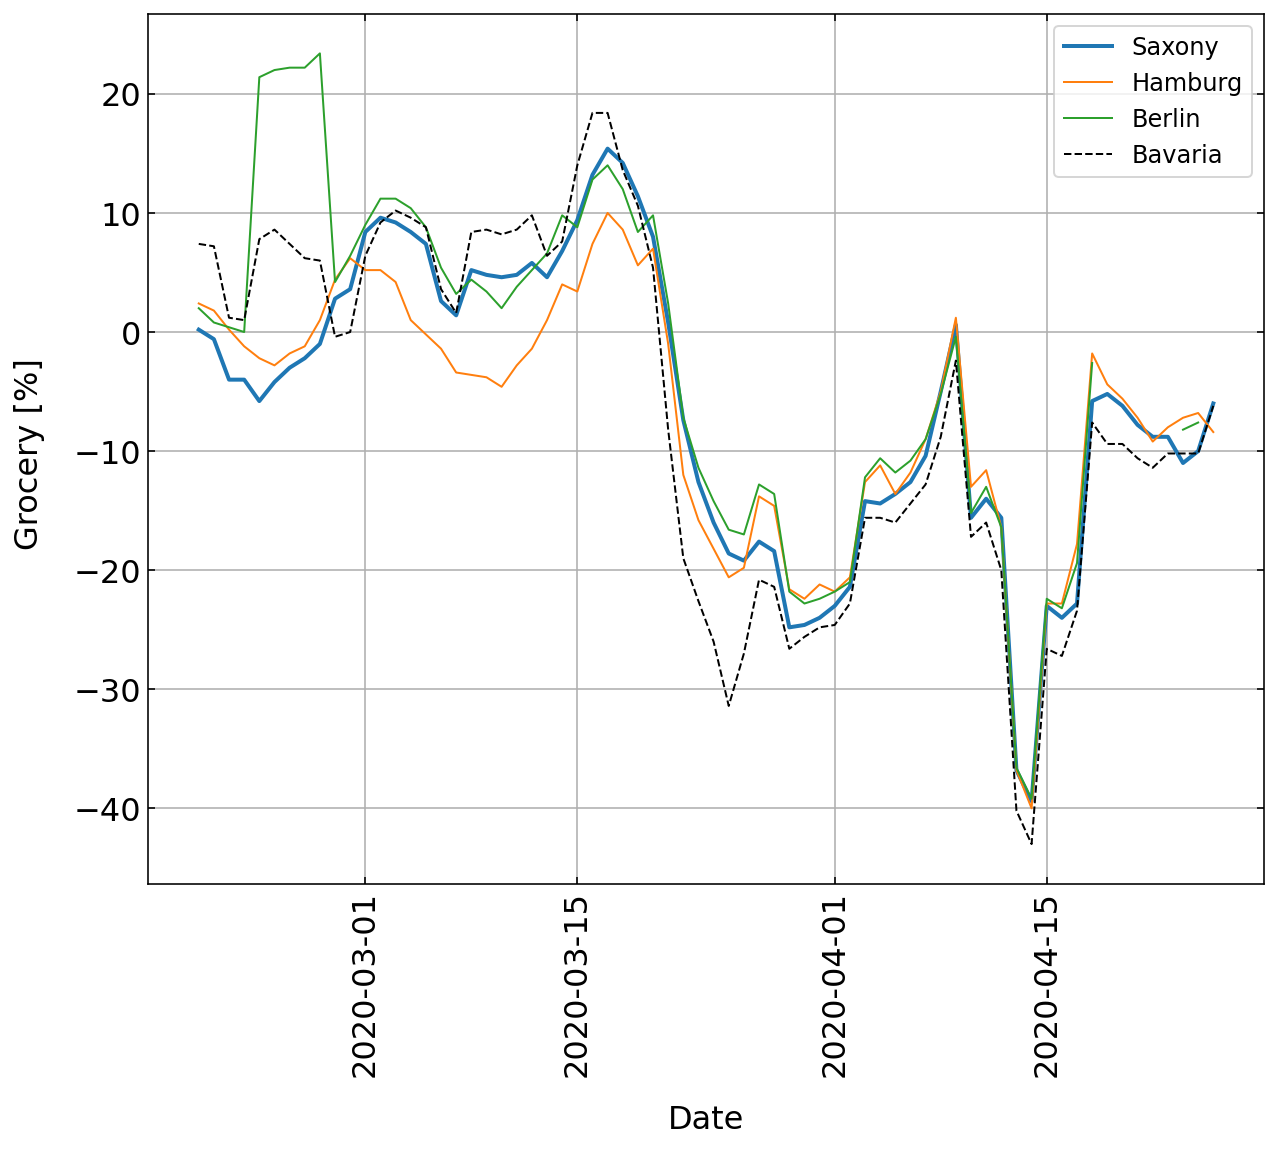

In [289]:
plt.figure(figsize=(10,8))
condition=goo_mob.sub_region_1=='Saxony'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].grocery_and_pharmacy_percent_change_from_baseline.rolling(5).mean(),lw=2,label='Saxony')
condition=goo_mob.sub_region_1=='Hamburg'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].grocery_and_pharmacy_percent_change_from_baseline.rolling(5).mean(),label='Hamburg')
condition=goo_mob.sub_region_1=='Berlin'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].grocery_and_pharmacy_percent_change_from_baseline.rolling(5).mean(),label='Berlin')
condition=goo_mob.sub_region_1=='Bavaria'
plt.plot(pd.to_datetime(goo_mob[condition].date.values),goo_mob[condition].grocery_and_pharmacy_percent_change_from_baseline.rolling(5).mean(),'k--',label='Bavaria')
plt.legend()
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Grocery [%] ')
plt.grid()
plt.show()